# In-Class Exercise on Plagiarism Detection
Overview
In this assignment, we will sequentially practice the steps to build a plagiarism detection application using a pre-trained Word2Vec model.

Data: https://s3.amazonaws.com/video.udacity-data.com/topher/2019/January/5c4147f9_data/data.zip

This exercise requires knowledeg of Python programming with the following libraries:

`gensim` (to load the Word2Vec model)

`numpy` (to compute similarity)

Additionally, we will use a pre-trained Word2Vec model Google's pre-trained word2vec model

Steps to Solve This Exercise
+ Exploring the Dataset  
+ Build a class for computing document similarity (`DocSim` class)
+ Create an instance of the above class (Load the pre-trained word embedding model, Create a list of stopwords and create an instance of the `DocSim` class)
+ Plagiarism Detection and Evaluation

In [ ]:
!wget https://s3.amazonaws.com/video.udacity-data.com/topher/2019/January/5c4147f9_data/data.zip
!unzip data

--2025-02-20 04:02:00--  https://s3.amazonaws.com/video.udacity-data.com/topher/2019/January/5c4147f9_data/data.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.165.0, 52.216.30.70, 52.217.199.232, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.165.0|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 113826 (111K) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>] 111.16K  --.-KB/s    in 0.08s   

2025-02-20 04:02:01 (1.43 MB/s) - ‘data.zip’ saved [113826/113826]

Archive:  data.zip
   creating: data/
  inflating: data/.DS_Store          
   creating: __MACOSX/
   creating: __MACOSX/data/
  inflating: __MACOSX/data/._.DS_Store  
  inflating: data/file_information.csv  
  inflating: __MACOSX/data/._file_information.csv  
  inflating: data/g0pA_taska.txt     
  inflating: __MACOSX/data/._g0pA_taska.txt  
  inflating: data/g0pA_taskb.txt     
  inflating: __MACOSX/data/._g0pA_taskb.txt  
  inflating: data

# Step 1: Exploring the Dataset  

In [ ]:
# import libraries
import pandas as pd
import numpy as np
import os

In [ ]:
csv_file = 'data/file_information.csv'
df = pd.read_csv(csv_file)

# print out the first few rows of data info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   File      100 non-null    object
 1   Task      100 non-null    object
 2   Category  100 non-null    object
dtypes: object(3)
memory usage: 2.5+ KB


In [ ]:
df.head()

,File,Task,Category
0,g0pA_taska.txt,a,non
1,g0pA_taskb.txt,b,cut
2,g0pA_taskc.txt,c,light
3,g0pA_taskd.txt,d,heavy
4,g0pA_taske.txt,e,non


In [ ]:
print('Number of files: ', df.shape[0])  # .shape[0] gives the rows
# .unique() gives unique items in a specified column
print('Number of unique tasks/question types (A-E): ', (df['Task'].unique()))
print('Unique plagiarism categories: ', (df['Category'].unique()))

Number of files:  100
Number of unique tasks/question types (A-E):  ['a' 'b' 'c' 'd' 'e']
Unique plagiarism categories:  ['non' 'cut' 'light' 'heavy' 'orig']




> In total there are 100 files, 95 of which are answers (submitted by people) and 5 of which are the original, Wikipedia source texts.



# Five task types, A-E
+ Each text file contains an answer to one short question; these questions are labeled as tasks A-E.

+ Each task, A-E, is about a topic that might be included in the Computer Science curriculum that was created by the authors of this dataset.

#Four categories of plagiarism
Each text file has an associated plagiarism label/category:

+ cut: An answer is plagiarized; it is copy-pasted directly from the relevant Wikipedia source text.
+ light: An answer is plagiarized; it is based on the Wikipedia source text and includes some copying and paraphrasing.
+ heavy: An answer is plagiarized; it is based on the Wikipedia source text but expressed using different words and structure. Since this doesn't copy directly from a source text, this will likely be the most challenging kind of plagiarism to detect.
+ non: An answer is not plagiarized; the Wikipedia source text is not used to create this answer.
+ orig: This is a specific category for the original, Wikipedia source text. We will use these files only for comparison purposes.


> The only category that does not contain any plagiarism is non.



# Distribution of Data (EDA)

In [ ]:
# Show counts by different tasks and amounts of plagiarism

# group and count by task
counts_per_task=df.groupby(['Task']).size().reset_index(name="Counts")
print("\nTask:")
display(counts_per_task)

# group by plagiarism level
counts_per_category=df.groupby(['Category']).size().reset_index(name="Counts")
print("\nPlagiarism Levels:")
display(counts_per_category)

# group by task AND plagiarism level
counts_task_and_plagiarism=df.groupby(['Task', 'Category']).size().reset_index(name="Counts")
print("\nTask & Plagiarism Level Combos :")
display(counts_task_and_plagiarism)


Task:


,Task,Counts
0,a,20
1,b,20
2,c,20
3,d,20
4,e,20



Plagiarism Levels:


,Category,Counts
0,cut,19
1,heavy,19
2,light,19
3,non,38
4,orig,5



Task & Plagiarism Level Combos :


,Task,Category,Counts
0,a,cut,4
1,a,heavy,3
2,a,light,3
3,a,non,9
4,a,orig,1
5,b,cut,3
6,b,heavy,4
7,b,light,3
8,b,non,9
9,b,orig,1


<BarContainer object of 25 artists>

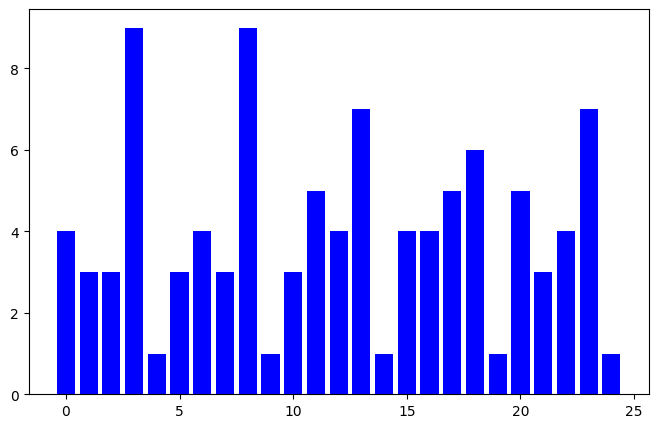

In [ ]:
import matplotlib.pyplot as plt

group = ['Task', 'Category']
counts = df.groupby(group).size().reset_index(name="Counts")
# print(counts)

plt.figure(figsize=(8,5))
plt.bar(range(len(counts)), counts['Counts'], color = 'blue')

+ The bar chart shows a highly variable distribution of counts across different task-category combinations.
+ Some categories have significantly higher counts, while others are much lower. The data does not appear uniformly distributed, with certain tasks or categories dominating the dataset.
+ There are noticeable peaks where specific combinations have high frequencies, suggesting that some tasks or categories are more common than others.
+ The overall pattern seems somewhat random, with fluctuations in counts rather than a clear trend.

# Step 2: Build a class for computing document similarity (`DocSim` class)

# Preprocessing function

In [ ]:
import pandas as pd

def process_csv_data(csv_file):
    """
    Reads a CSV file containing `File`, `Category`, and `Task` columns, then:
    1) Converts `Category` column values into numerical values.
    2) Adds a new `Class` column to label plagiarism cases.

    Class labeling:
      - Plagiarized answers: 1
      - Non-plagiarized answers: 0
      - Source texts: -1

    :param csv_file: Path to the CSV file.
    :return: DataFrame with numerical `Category` and `Class` columns.
    """
    # Read CSV file
    data = pd.read_csv(csv_file)

    # Convert category values to numerical form
    category_mapping = {'non': 0, 'heavy': 1, 'light': 2, 'cut': 3, 'orig': -1}
    data['Category'] = data['Category'].map(category_mapping)

    # Assign Class labels
    data['Class'] = data['Category'].apply(lambda x: 0 if x == 0 else (-1 if x == -1 else 1))

    return data


In [ ]:
transformed_df = process_csv_data(csv_file ='data/file_information.csv')
transformed_df.head(10)

,File,Task,Category,Class
0,g0pA_taska.txt,a,0,0
1,g0pA_taskb.txt,b,3,1
2,g0pA_taskc.txt,c,2,1
3,g0pA_taskd.txt,d,1,1
4,g0pA_taske.txt,e,0,0
5,g0pB_taska.txt,a,0,0
6,g0pB_taskb.txt,b,0,0
7,g0pB_taskc.txt,c,3,1
8,g0pB_taskd.txt,d,2,1
9,g0pB_taske.txt,e,1,1


In [ ]:
import re
def preprocess_file(file):
  """Pre-processes a text file by converting to lowercase and removing non-alphanumeric characters."""
  all_text = file.read().lower()
  all_text = re.sub(r"[^a-zA-Z0-9\s]", " ", all_text)  # Keep spaces to preserve words
  all_text = re.sub(r"\s+", " ", all_text).strip()  # Replace multiple spaces with a single space
  return all_text

In [ ]:
import os

def create_text_column(df, file_directory="data/"):
    """
    Reads files listed in a dataframe and returns a new dataframe with an additional `Text` column.

    :param df: DataFrame containing a column `File` with filenames.
    :param file_directory: Directory where files are stored.
    :return: DataFrame with an additional `Text` column containing processed text.
    """
    text_df = df.copy()

    def read_and_process(filename):
        """Helper function to read and process a file."""
        file_path = os.path.join(file_directory, filename)
        try:
            with open(file_path, "r", encoding="utf-8", errors="ignore") as file:
                return preprocess_file(file)
        except FileNotFoundError:
            return ""  # Return empty string if file is missing

    # Apply function to each row and create a new `Text` column
    text_df["Text"] = text_df["File"].apply(read_and_process)

    return text_df


In [ ]:
text_df = create_text_column(transformed_df)
text_df.head()

,File,Task,Category,Class,Text
0,g0pA_taska.txt,a,0,0,inheritance is a basic concept of object orien...
1,g0pA_taskb.txt,b,3,1,pagerank is a link analysis algorithm used by ...
2,g0pA_taskc.txt,c,2,1,the vector space model also called term vector...
3,g0pA_taskd.txt,d,1,1,bayes theorem was names after rev thomas bayes...
4,g0pA_taske.txt,e,0,0,dynamic programming is an algorithm design tec...


In [ ]:
!pip install gensim numpy

# Load Google’s Pre-trained Word2Vec Model

In [ ]:
import gensim.downloader as api

# Load the pre-trained Word2Vec model (smaller version)
word2vec_model = api.load("word2vec-google-news-300")  # Loads Google's 300D model
print("Word2Vec Model Loaded!")

# Build the DocSim Class

In [ ]:
import numpy as np
import gensim
import nltk
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import cosine_similarity

# Download stopwords
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

class DocSim:
    def __init__(self, model, stopwords=None):
        self.model = model
        self.stopwords = stopwords if stopwords else []

    def vectorize(self, text):
        """Convert text into a vector using Word2Vec embeddings"""
        words = [word for word in text.lower().split() if word not in self.stopwords]
        word_vectors = [self.model[word] for word in words if word in self.model]
        if not word_vectors:
            return np.zeros(300)  # Return zero vector if no words found
        return np.mean(word_vectors, axis=0)

    def cosine_similarity(self, vec1, vec2):
        """Compute cosine similarity using NumPy"""
        dot_product = np.dot(vec1, vec2)
        norm_vec1 = np.linalg.norm(vec1)
        norm_vec2 = np.linalg.norm(vec2)

        # Prevent division by zero
        if norm_vec1 == 0 or norm_vec2 == 0:
            return 0.0

        return dot_product / (norm_vec1 * norm_vec2)

    def similarity(self, text1, text2):
        """Compute similarity between two texts"""
        vec1 = self.vectorize(text1)
        vec2 = self.vectorize(text2)
        return self.cosine_similarity(vec1, vec2)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Step 3: Create an instance of the above class (Load the pre-trained word embedding model, Create a list of stopwords and create an instance of the `DocSim` class)

In [ ]:
doc_sim = DocSim(word2vec_model, stopwords=stop_words)

# Step 4: Plagiarism Detection and Evaluation

In [ ]:
source_texts = text_df[text_df["Class"] == -1][["Task", "Text"]].set_index("Task")["Text"].to_dict()

In [ ]:
print(source_texts)

{'a': 'in object oriented programming inheritance is a way to form new classes instances of which are called objects using classes that have already been defined the inheritance concept was invented in 1967 for simula the new classes known as derived classes take over or inherit attributes and behavior of the pre existing classes which are referred to as base classes or ancestor classes it is intended to help reuse existing code with little or no modification inheritance provides the support for representation by categorization in computer languages categorization is a powerful mechanism number of information processing crucial to human learning by means of generalization what is known about specific entities is applied to a wider group given a belongs relation can be established and cognitive economy less information needs to be stored about each specific entity only its particularities inheritance is also sometimes called generalization because the is a relationships represent a hier

In [ ]:
results = []

# Compare student submissions against the source text
for index, row in text_df.iterrows():
    if row["Class"] == -1:  # Skip non-plagiarized and source texts
        continue

    student_text = row["Text"]
    task = row["Task"]

    if task not in source_texts:
        continue  # Skip if there's no matching source text

    source_text = source_texts[task]
    similarity_score = doc_sim.similarity(student_text, source_text)

    # Store results
    results.append({
        "File": row["File"],
        "Task": row["Task"],
        "Category": row["Category"],
        "Class": row["Class"],
        "Similarity Score": similarity_score
    })

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

In [ ]:
print(results_df)

              File Task  Category  Class  Similarity Score
0   g0pA_taska.txt    a         0      0          0.793344
1   g0pA_taskb.txt    b         3      1          0.966685
2   g0pA_taskc.txt    c         2      1          0.985389
3   g0pA_taskd.txt    d         1      1          0.857035
4   g0pA_taske.txt    e         0      0          0.916362
..             ...  ...       ...    ...               ...
90  g4pE_taska.txt    a         1      1          0.898071
91  g4pE_taskb.txt    b         2      1          0.970754
92  g4pE_taskc.txt    c         3      1          0.923581
93  g4pE_taskd.txt    d         0      0          0.790500
94  g4pE_taske.txt    e         0      0          0.878475

[95 rows x 5 columns]


# Evaluate Plagiarism Detection

In [ ]:
threshold = 0.85

results_df["Plagiarized"] = results_df["Similarity Score"] > threshold

print(results_df)

              File Task  Category  Class  Similarity Score  Plagiarized
0   g0pA_taska.txt    a         0      0          0.793344        False
1   g0pA_taskb.txt    b         3      1          0.966685         True
2   g0pA_taskc.txt    c         2      1          0.985389         True
3   g0pA_taskd.txt    d         1      1          0.857035         True
4   g0pA_taske.txt    e         0      0          0.916362         True
..             ...  ...       ...    ...               ...          ...
90  g4pE_taska.txt    a         1      1          0.898071         True
91  g4pE_taskb.txt    b         2      1          0.970754         True
92  g4pE_taskc.txt    c         3      1          0.923581         True
93  g4pE_taskd.txt    d         0      0          0.790500        False
94  g4pE_taske.txt    e         0      0          0.878475         True

[95 rows x 6 columns]


# Compute Precision, Recall, F1-score

In [ ]:
from sklearn.metrics import classification_report


y_true = text_df[text_df["Class"] != -1]["Class"].values  # Exclude source texts (-1)
y_pred = results_df["Plagiarized"].astype(int).values

# Ensure both arrays are the same length
min_len = min(len(y_true), len(y_pred))
y_true, y_pred = y_true[:min_len], y_pred[:min_len]

# Print evaluation metrics
print(classification_report(y_true, y_pred, target_names=["Non-Plagiarized", "Plagiarized"]))


                 precision    recall  f1-score   support

Non-Plagiarized       0.77      0.26      0.39        38
    Plagiarized       0.66      0.95      0.78        57

       accuracy                           0.67        95
      macro avg       0.71      0.61      0.58        95
   weighted avg       0.70      0.67      0.62        95



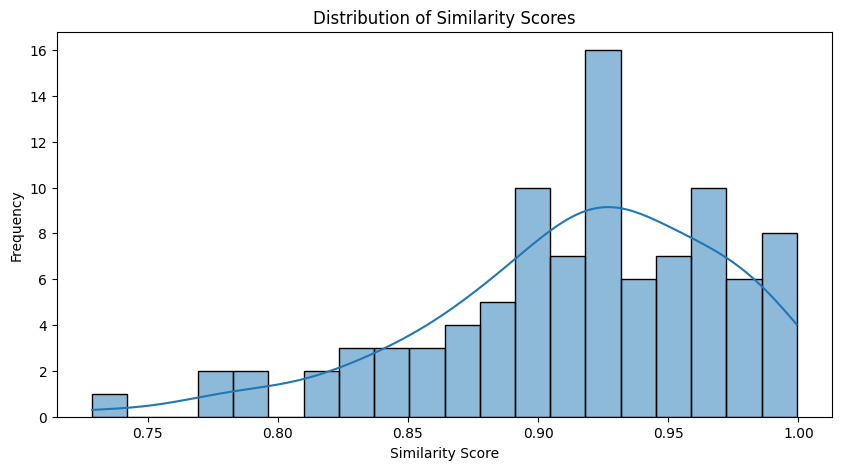

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.histplot(results_df["Similarity Score"], bins=20, kde=True)
plt.title("Distribution of Similarity Scores")
plt.xlabel("Similarity Score")
plt.ylabel("Frequency")
plt.show()

# ROC Analysis

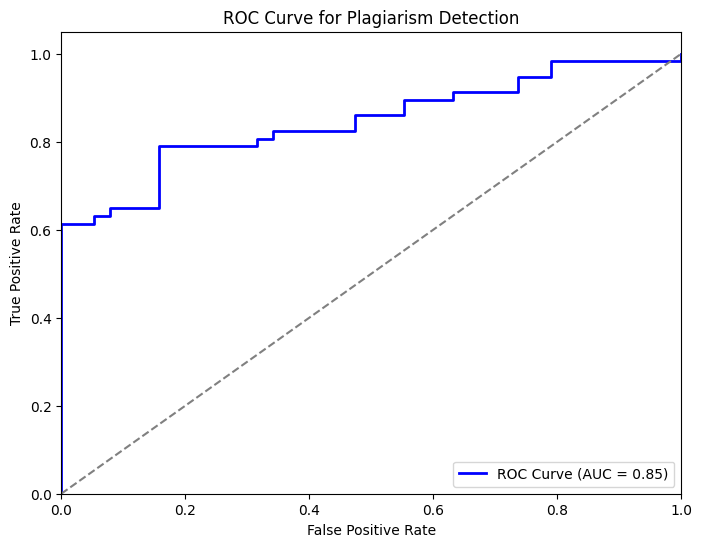

In [ ]:
from sklearn.metrics import roc_curve, auc

# Prepare ground truth labels (0 = Non-plagiarized, 1 = Plagiarized)
y_true = text_df[text_df["Class"] != -1]["Class"].values  # Exclude source texts (-1)

# Extract similarity scores
y_scores = results_df["Similarity Score"].values

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="grey", linestyle="--")  # Diagonal baseline
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Plagiarism Detection")
plt.legend(loc="lower right")
plt.show()

**The ROC curve** shows that the plagiarism detection model performs well, with an AUC score of 0.85, indicating a high ability to distinguish between plagiarized and non-plagiarized texts.

The curve stays above the diagonal baseline, meaning the model makes better-than-random predictions. However, there is still room for improvement, especially in reducing false positives and further optimizing the decision threshold.